<a href="https://colab.research.google.com/github/anshika-pathakk/ML-Lab_Experiments/blob/main/Exp5/Decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment-5: Decision Trees from Scratch
**Date:** October 8, 2025

---

## Objective
In this assignment, you will implement a **Decision Tree Classifier from scratch** using `numpy` and apply it to the **Adult Income Dataset**.

**Task:** Predict whether a person earns more than $50K per year.

You will:
1. Build a decision tree from scratch.
2. Evaluate it using standard metrics.
3. Perform **pre-pruning** and **post-pruning** to improve generalization.


In [ ]:
! pip install ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

We will use the **Adult Income Dataset** from UCI.

- **Dataset Link:** [Adult Dataset (UCI Machine Learning Repository)](https://archive.ics.uci.edu/ml/datasets/adult)
- **Task:** Binary Classification — predict whether a person earns **≤ 50K** or **> 50K** per year.
- **Features:**  
  Mix of **categorical** and **numeric** features:
  - *Categorical:* `workclass`, `education`, `occupation`, `marital-status`, etc.
  - *Numeric:* `age`, `hours-per-week`, `capital-gain`, `capital-loss`, etc.
- **Target Variable:**  
  `income` — indicates whether the person earns **≤ 50K** or **> 50K**.



In [ ]:
from ucimlrepo import fetch_ucirepo

In [ ]:
adult = fetch_ucirepo(id=2)
X = adult.data.features # features (pandas DataFrame)
y = adult.data.targets # target (pandas DataFrame)

In [ ]:
print("Shape of features:", X.shape)
y = y.iloc[:, 0]
print("Unique target labels:", y.unique())

Shape of features: (48842, 14)
Unique target labels: ['<=50K' '>50K' '<=50K.' '>50K.']


In [ ]:
# metadata
print(adult.metadata)

# variable information
print(adult.variables)

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

## 🧹 1. Data Preparation

- Handle missing values (drop or impute).  
- Encode categorical variables into numeric values (e.g., Label Encoding).  
- Split the dataset as follows:
  - **80% Training**
  - **20% Validation**
  - **20% Test**

> Use the validation set to tune tree depth and pruning parameters.


In [ ]:
# Combine for easier preprocessing
data = pd.concat([X, y], axis=1)
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# Check missing values
print("Missing values per column:\n", data.isnull().sum())

# In the Adult dataset, missing values are represented as '?'
# Let's check for that
print("\nColumns containing '?':")
for col in data.columns:
    if (data[col] == '?').sum() > 0:
        print(f"{col}: {(data[col] == '?').sum()}")

# Replace '?' with NaN for easier handling
data.replace('?', np.nan, inplace=True)


Missing values per column:
 age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

Columns containing '?':
workclass: 1836
occupation: 1843
native-country: 583


In [ ]:
# Option 1: Drop rows with missing values
# (You can also impute them, but dropping is simpler for now)
data.dropna(inplace=True)
print("After dropping missing values, shape:", data.shape)


After dropping missing values, shape: (45222, 15)


In [ ]:
categorical_cols = data.select_dtypes(include=['object']).columns
print("Categorical columns:", list(categorical_cols))

# Create a dictionary of encoders
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le  # store encoder for later decoding if needed

print("\nAfter encoding:")
data.head()


Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']

After encoding:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0


In [ ]:
# Separate features and target again
X = data.drop('income', axis=1)
y = data['income']

print("Feature shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Feature shape: (45222, 14)
Target distribution:
 income
0    22654
1    11360
2     7508
3     3700
Name: count, dtype: int64


In [ ]:
# First split: Train + Temp (Val+Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: Validation + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Train set: (27133, 14)
Validation set: (9044, 14)
Test set: (9045, 14)


In [ ]:
numeric_cols = ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                    'relationship', 'race', 'sex', 'native-country']


## 🌳 2. Build a Decision Tree from Scratch

Implement the tree recursively:

1. **At each split:**
   - Compute both **Gini Impurity** and **Entropy**.
   - For each feature and possible split, calculate the **weighted impurity** of child nodes.
   - Choose the split with the **highest information gain** (lowest impurity).

2. **Continue splitting until:**
   - All samples in a node have the same label, **OR**
   - The **maximum depth** is reached, **OR**
   - There is **no further improvement** in impurity.

3. **Implement a function** to predict labels for new samples.


In [ ]:
def gini_impurity(y):
    counts = np.bincount(y)
    probs = counts / counts.sum()
    return 1 - np.sum(probs**2)


In [ ]:
def entropy_impurity(y):
    counts = np.bincount(y)
    probs = counts / counts.sum()
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

In [ ]:
class TreeNode:
    def __init__(self, depth=0):
        self.depth = depth
        self.is_leaf = False
        self.prediction = None
        self.feature = None
        self.threshold = None
        self.left = None
        self.right = None
        self.samples = 0
        self.feature_name = None

In [ ]:
class DecisionTreeFromScratch:
    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2, min_impurity_decrease=1e-4,
                 feature_names=None, numeric_cols=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.feature_names = feature_names
        self.numeric_cols = set(numeric_cols) if numeric_cols else set()

    def _impurity(self, y):
        return gini_impurity(y) if self.criterion == 'gini' else entropy_impurity(y)

    def _best_split(self, X, y):
        best_gain, best_feat, best_thr = 0, None, None
        base_imp = self._impurity(y)
        n, m = X.shape

        for i in range(m):
            col = X[:, i]
            feature_name = self.feature_names[i]
            is_num = feature_name in self.numeric_cols
            vals = np.unique(col)
            if len(vals) <= 1: continue

            thresholds = (vals[:-1] + vals[1:]) / 2 if is_num else vals
            for thr in thresholds:
                if is_num:
                    left = y[col <= thr]
                    right = y[col > thr]
                else:
                    left = y[col == thr]
                    right = y[col != thr]
                if len(left) == 0 or len(right) == 0:
                    continue

                imp = (len(left)*self._impurity(left) + len(right)*self._impurity(right)) / n
                gain = base_imp - imp

                if gain > best_gain:
                    best_gain, best_feat, best_thr = gain, i, thr

        return best_feat, best_thr, best_gain

    def _build(self, X, y, depth=0):
        node = TreeNode(depth)
        node.samples = len(y)
        node.prediction = Counter(y).most_common(1)[0][0]

        # ✅ Pre-pruning checks
        if (len(set(y)) == 1 or
            (self.max_depth and depth >= self.max_depth) or
            len(y) < self.min_samples_split):
            node.is_leaf = True
            return node

        feat, thr, gain = self._best_split(X, y)
        if feat is None or gain < self.min_impurity_decrease:
            node.is_leaf = True
            return node

        node.feature = feat
        node.threshold = thr
        node.feature_name = self.feature_names[feat]

        col = X[:, feat]
        left_idx = col <= thr if node.feature_name in self.numeric_cols else col == thr

        node.left = self._build(X[left_idx], y[left_idx], depth + 1)
        node.right = self._build(X[~left_idx], y[~left_idx], depth + 1)
        return node

    def fit(self, X, y):
        self.classes_, y_enc = np.unique(y, return_inverse=True)
        self.root = self._build(X.values, y_enc, 0)

    def _predict_one(self, x, node):
        if node.is_leaf:
            return node.prediction
        val = x[node.feature]
        if node.feature_name in self.numeric_cols:
            return self._predict_one(x, node.left if val <= node.threshold else node.right)
        else:
            return self._predict_one(x, node.left if val == node.threshold else node.right)

    def predict(self, X):
        return np.array([self._predict_one(row, self.root) for row in X.values])


## ✂️ 3. Pre-Pruning (Restricting Tree Growth)

While building the tree, apply pre-pruning techniques:

- Limit **maximum depth** (try depths = 2, 4, 6, and unlimited).  
- Require at least a **minimum number of samples** (e.g., 5) to split.  
- Optionally, require a **minimum impurity decrease** to split further.


In [ ]:
# Try different depths (pre-pruning)
depths = [2, 4, 6, None]
results = []

for d in depths:
    tree = DecisionTreeFromScratch(
        criterion='gini',
        max_depth=d,
        min_samples_split=5,
        min_impurity_decrease=1e-3,
        feature_names=X_train.columns.tolist(),
        numeric_cols=numeric_cols
    )
    tree.fit(X_train, y_train)
    preds = tree.predict(X_val)

    prec = precision_score(y_val, preds, average='weighted')
    rec = recall_score(y_val, preds, average='weighted')
    f1 = f1_score(y_val, preds, average='weighted')

    acc = accuracy_score(y_val, preds)

    cm = confusion_matrix(y_val, preds)

    results.append({
        'Max Depth': d if d else 'Unlimited',
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

results_df_gini = pd.DataFrame(results)
display(results_df_gini)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Max Depth,Accuracy,Precision,Recall,F1 Score
0,2,0.547214,0.360658,0.547214,0.428245
1,4,0.558271,0.393812,0.558271,0.440560
2,6,0.566232,0.408090,0.566232,0.449137
3,Unlimited,0.502543,0.452781,0.502543,0.465744


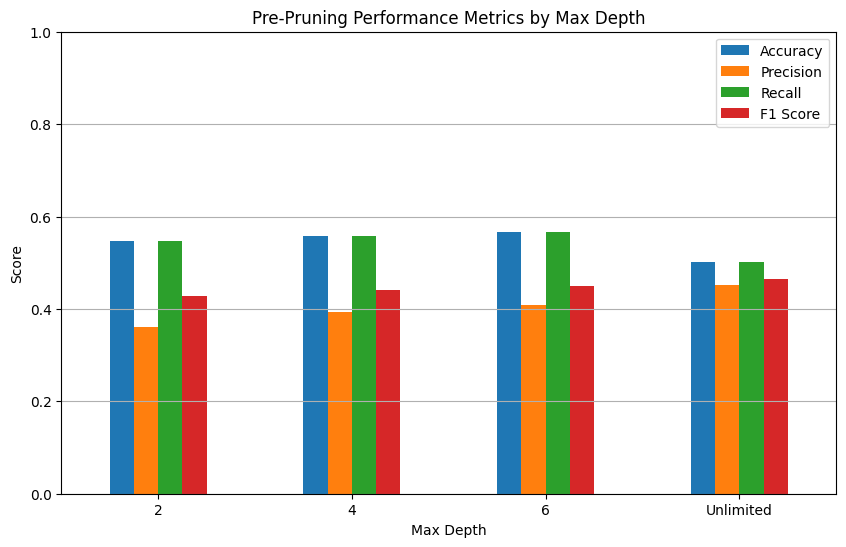

In [ ]:
# --- Prepare summary metrics table ---
metrics_df = results_df_gini[['Max Depth', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]
metrics_df.set_index('Max Depth', inplace=True)
metrics_df

# --- Plot Accuracy, Precision, Recall, F1 Score for different depths ---
metrics_df.plot(kind='bar', figsize=(10,6))
plt.title('Pre-Pruning Performance Metrics by Max Depth')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


In [ ]:
# Try different depths (pre-pruning)
depths = [2, 4, 6, None]
results = []

for d in depths:
    tree = DecisionTreeFromScratch(
        criterion='entropy',
        max_depth=d,
        min_samples_split=5,
        min_impurity_decrease=1e-3,
        feature_names=X_train.columns.tolist(),
        numeric_cols=numeric_cols
    )
    tree.fit(X_train, y_train)
    preds = tree.predict(X_val)

    prec = precision_score(y_val, preds, average='weighted')
    rec = recall_score(y_val, preds, average='weighted')
    f1 = f1_score(y_val, preds, average='weighted')

    acc = accuracy_score(y_val, preds)

    cm = confusion_matrix(y_val, preds)


    results.append({
        'Max Depth': d if d else 'Unlimited',
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

results_df_entropy = pd.DataFrame(results)
display(results_df_entropy)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Max Depth,Accuracy,Precision,Recall,F1 Score
0,2,0.547214,0.360658,0.547214,0.428245
1,4,0.558381,0.396606,0.558381,0.440223
2,6,0.563799,0.473635,0.563799,0.447817
3,Unlimited,0.455882,0.454110,0.455882,0.454970


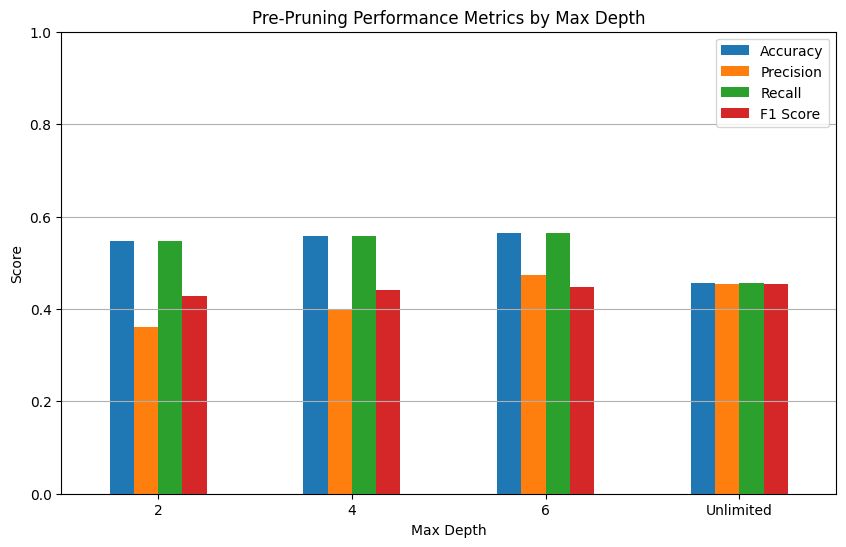

In [ ]:
# --- Prepare summary metrics table ---
metrics_df = results_df_entropy[['Max Depth', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]
metrics_df.set_index('Max Depth', inplace=True)
metrics_df

# --- Plot Accuracy, Precision, Recall, F1 Score for different depths ---
metrics_df.plot(kind='bar', figsize=(10,6))
plt.title('Pre-Pruning Performance Metrics by Max Depth')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## 🪚 4. Post-Pruning (Reduced Error Pruning)

Steps for reduced error pruning:

1. First, **grow a full tree**.  
2. For each internal node:
   - Replace it with a **leaf node** (majority class).
   - Evaluate **validation accuracy**.
3. If accuracy **does not decrease**, keep the pruning.  
4. Repeat until no further improvement is observed.


In [ ]:
from sklearn.metrics import accuracy_score
def reduced_error_pruning(tree, X_val, y_val):
    """
    Perform Reduced Error Pruning externally on a trained DecisionTreeFromScratch model.
    """
    y_val_enc = np.array([np.where(tree.classes_ == c)[0][0] for c in y_val])
    base_acc = accuracy_score(y_val_enc, tree.predict(X_val))
    improved = True

    print(f"Initial validation accuracy: {base_acc:.4f}")

    # --- Helper: get all internal nodes ---
    def get_internal_nodes(node):
        if node.is_leaf or node is None:
            return []
        nodes = [node]
        nodes.extend(get_internal_nodes(node.left))
        nodes.extend(get_internal_nodes(node.right))
        return nodes

    # --- Helper: evaluate the tree after pruning ---
    def evaluate_prune(node):
        nonlocal base_acc
        if node is None or node.is_leaf:
            return False

        # Save current state
        backup = (node.is_leaf, node.left, node.right)
        node.is_leaf = True
        node.left = None
        node.right = None

        preds = tree.predict(X_val)
        acc = accuracy_score(y_val_enc, preds)

        # Decide to keep or revert
        if acc >= base_acc:
            base_acc = acc
            return True
        else:
            node.is_leaf, node.left, node.right = backup
            return False

    # --- Iteratively prune until no more improvement ---
    iteration = 0
    while improved:
        improved = False
        nodes = get_internal_nodes(tree.root)
        for node in nodes:
            if evaluate_prune(node):
                improved = True
        iteration += 1
        print(f"Iteration {iteration}: accuracy = {base_acc:.4f}")

    print(f"✅ Post-pruning complete. Final validation accuracy: {base_acc:.4f}")
    return base_acc


Before pruning accuracy: 0.45588235294117646
Initial validation accuracy: 0.4559
Iteration 1: accuracy = 0.5010
Iteration 2: accuracy = 0.5010
✅ Post-pruning complete. Final validation accuracy: 0.5010


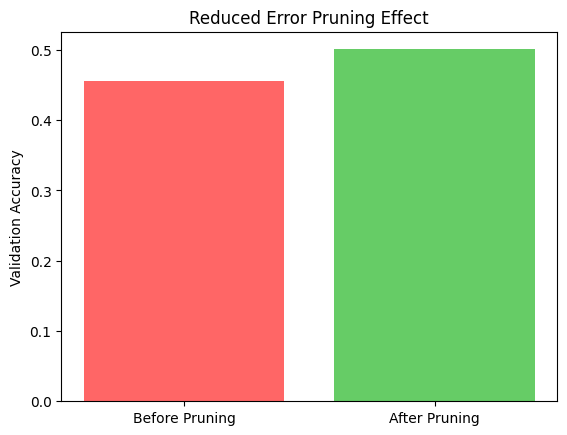

In [ ]:
# Train full tree (no pre-pruning)
tree = DecisionTreeFromScratch(
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_impurity_decrease=1e-4,
    feature_names=X_train.columns.tolist(),
    numeric_cols=numeric_cols
)
tree.fit(X_train, y_train)

# Accuracy before pruning
before_acc = accuracy_score(y_val, tree.predict(X_val))
print("Before pruning accuracy:", before_acc)

# Apply post-pruning externally
after_acc = reduced_error_pruning(tree, X_val, y_val)

# Visualize improvement
plt.bar(['Before Pruning', 'After Pruning'], [before_acc, after_acc], color=['#FF6666', '#66CC66'])
plt.ylabel('Validation Accuracy')
plt.title('Reduced Error Pruning Effect')
plt.show()


## 🧾 5. Evaluation

- Train using the **training set**.
- Tune depth and pruning using the **validation set**.
- Report final results on the **test set**.

### Metrics to Report
- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**
- **Confusion Matrix**

> Compare your implementation with `sklearn.tree.DecisionTreeClassifier`.


In [ ]:
# Fit tree on full training + validation set if needed
best_depth = 6  # from previous validation tuning
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)
tree_final = DecisionTreeFromScratch(
    criterion='gini',  # or best criterion
    max_depth=best_depth,  # from validation tuning
    min_samples_split=5,
    min_impurity_decrease=1e-3,
    feature_names=X_train.columns.tolist(),
    numeric_cols=numeric_cols
)
tree_final.fit(X_train_val, y_train_val)

# Apply post-pruning externally
reduced_error_pruning(tree_final, X_val, y_val)  # optional

# Predict on test set
preds_test = tree_final.predict(X_test)

# Metrics
acc = accuracy_score(y_test, preds_test)
prec = precision_score(y_test, preds_test, average='weighted')
rec = recall_score(y_test, preds_test, average='weighted')
f1 = f1_score(y_test, preds_test, average='weighted')
cm = confusion_matrix(y_test, preds_test)

print("Test Accuracy:", acc)
print("Test Precision:", prec)
print("Test Recall:", rec)
print("Test F1-score:", f1)
print("Confusion Matrix:\n", cm)


Initial validation accuracy: 0.5701
Iteration 1: accuracy = 0.5703
Iteration 2: accuracy = 0.5703
✅ Post-pruning complete. Final validation accuracy: 0.5703
Test Accuracy: 0.5630735212824765
Test Precision: 0.6581534372526878
Test Recall: 0.5630735212824765
Test F1-score: 0.44561061104146105
Confusion Matrix:
 [[4325    0  206    0]
 [2173    1   97    1]
 [ 732    0  757   13]
 [ 339    0  391   10]]


In [ ]:
sk_tree = DecisionTreeClassifier(
    criterion='gini',  # best criterion
    max_depth=best_depth,
    min_samples_split=5
)
sk_tree.fit(X_train_val, y_train_val)
sk_preds = sk_tree.predict(X_test)

print("Sklearn Tree Metrics:")
print("Accuracy:", accuracy_score(y_test, sk_preds))
print("Precision:", precision_score(y_test, sk_preds, average='weighted'))
print("Recall:", recall_score(y_test, sk_preds, average='weighted'))
print("F1-score:", f1_score(y_test, sk_preds, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, sk_preds))


Sklearn Tree Metrics:
Accuracy: 0.561967938087341
Precision: 0.46565679893826395
Recall: 0.561967938087341
F1-score: 0.443719500759482
Confusion Matrix:
 [[4322    3  206    0]
 [2174    2   96    0]
 [ 740    1  756    5]
 [ 340    2  395    3]]


In [ ]:
# From scratch
y_pred_scratch = tree_final.predict(X_test)
metrics_scratch = {
    'Accuracy': accuracy_score(y_test, y_pred_scratch),
    'Precision': precision_score(y_test, y_pred_scratch, average='weighted'),
    'Recall': recall_score(y_test, y_pred_scratch, average='weighted'),
    'F1-score': f1_score(y_test, y_pred_scratch, average='weighted')
}

# Sklearn
sk_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=best_depth,
    min_samples_split=5
)
sk_tree.fit(X_train_val, y_train_val)
y_pred_sklearn = sk_tree.predict(X_test)
metrics_sklearn = {
    'Accuracy': accuracy_score(y_test, y_pred_sklearn),
    'Precision': precision_score(y_test, y_pred_sklearn, average='weighted'),
    'Recall': recall_score(y_test, y_pred_sklearn, average='weighted'),
    'F1-score': f1_score(y_test, y_pred_sklearn, average='weighted')
}


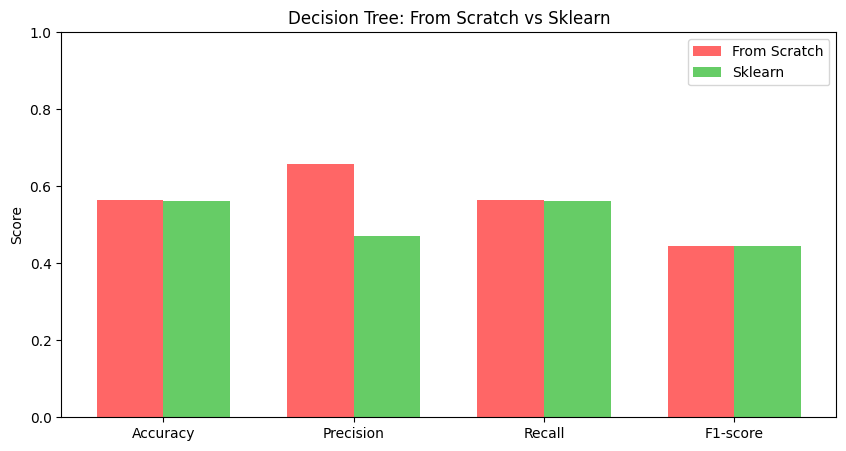

In [ ]:
metrics_names = list(metrics_scratch.keys())
scratch_values = list(metrics_scratch.values())
sklearn_values = list(metrics_sklearn.values())

x = np.arange(len(metrics_names))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, scratch_values, width, label='From Scratch', color='#FF6666')
plt.bar(x + width/2, sklearn_values, width, label='Sklearn', color='#66CC66')

plt.xticks(x, metrics_names)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Decision Tree: From Scratch vs Sklearn')
plt.legend()
plt.show()


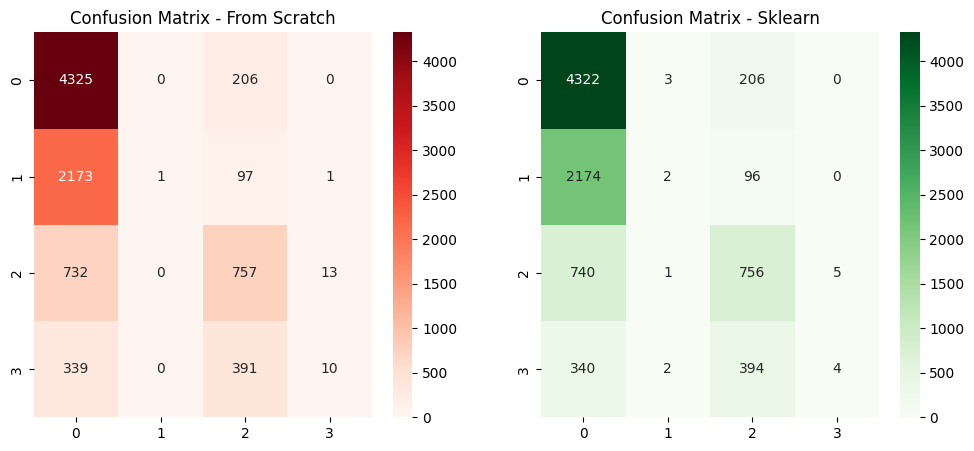

In [ ]:
cm_scratch = confusion_matrix(y_test, y_pred_scratch)
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(cm_scratch, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - From Scratch')

plt.subplot(1,2,2)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Sklearn')

plt.show()


## 🔬 6. Experiments to Perform

Perform and report the following experiments:

1. **Compare Gini vs. Entropy.**  
2. **Compare different depths** (2, 4, 6, unlimited).  
3. **Show the effect of pruning** (pre-pruned vs. post-pruned vs. full tree).  
4. **Identify the most important features** — the ones used near the top of the tree.


In [ ]:
criteria = ['gini', 'entropy']
results_criteria = []

for crit in criteria:
    tree = DecisionTreeFromScratch(
        criterion=crit,
        max_depth=None,
        min_samples_split=5,
        min_impurity_decrease=1e-3,
        feature_names=X_train.columns.tolist(),
        numeric_cols=numeric_cols
    )
    tree.fit(X_train, y_train)
    preds = tree.predict(X_val)

    results_criteria.append({
        'Criterion': crit,
        'Accuracy': accuracy_score(y_val, preds),
        'Precision': precision_score(y_val, preds, average='weighted'),
        'Recall': recall_score(y_val, preds, average='weighted'),
        'F1 Score': f1_score(y_val, preds, average='weighted')
    })

pd.DataFrame(results_criteria)


,Criterion,Accuracy,Precision,Recall,F1 Score
0,gini,0.502543,0.452781,0.502543,0.465744
1,entropy,0.455882,0.454110,0.455882,0.454970


In [ ]:
def get_feature_importance(node, importance=None, level=0):
    if importance is None:
        importance = Counter()
    if node.is_leaf:
        return importance
    # Give higher weight to features near the root
    importance[node.feature_name] += 1 / (level + 1)
    get_feature_importance(node.left, importance, level + 1)
    get_feature_importance(node.right, importance, level + 1)
    return importance

importance = get_feature_importance(tree.root)
sorted_features = importance.most_common()
print("Most important features (top first):")
for feat, score in sorted_features:
    print(f"{feat}: {score:.3f}")


Most important features (top first):
age: 130.576
fnlwgt: 96.980
occupation: 29.364
hours-per-week: 25.020
workclass: 19.772
education: 14.990
race: 6.400
native-country: 6.150
relationship: 6.001
capital-gain: 5.332
marital-status: 5.124
education-num: 4.871
capital-loss: 4.758
sex: 3.474
